In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

from xgboost import XGBClassifier

In [45]:
file_path = "DecodeX_VoltRide_Dataset.xlsx"

ride_df = pd.read_excel(file_path, sheet_name="Ride_Level_Data")
driver_df = pd.read_excel(file_path, sheet_name="Driver_Data")
zone_df = pd.read_excel(file_path, sheet_name="Zone_Hour_Demand")
charging_df = pd.read_excel(file_path, sheet_name="Charging_Stations")

In [46]:
print("Ride DF Columns:")
print(ride_df.columns)

print("\nDriver DF Columns:")
print(driver_df.columns)

print("\nZone DF Columns:")
print(zone_df.columns)

print("\nCharging DF Columns:")
print(charging_df.columns)

Ride DF Columns:
Index(['Ride_ID', 'City', 'Date', 'Hour', 'Pickup_Zone', 'Drop_Zone',
       'Ride_Distance_km', 'Estimated_Fare', 'Surge_Multiplier',
       'EV_Battery_%', 'Driver_Available', 'Charging_Station_Nearby',
       'Weather', 'Ride_Status', 'Cancellation_By'],
      dtype='object')

Driver DF Columns:
Index(['Driver_ID', 'City', 'Experience_Months', 'Avg_Rating',
       'Total_Rides_Last_30_Days', 'Avg_Battery_Consumption_km',
       'Cancellation_Rate_%'],
      dtype='object')

Zone DF Columns:
Index(['City', 'Zone', 'Hour', 'Avg_Ride_Requests', 'Avg_Cancellations'], dtype='object')

Charging DF Columns:
Index(['Station_ID', 'City', 'Zone', 'Chargers_Available',
       'Avg_Wait_Time_Min'],
      dtype='object')


In [47]:
df = ride_df.merge(
    zone_df,
    left_on=["City", "Pickup_Zone", "Hour"],
    right_on=["City", "Zone", "Hour"],
    how="left"
)

df = df.merge(
    charging_df,
    left_on=["City", "Pickup_Zone"],
    right_on=["City", "Zone"],
    how="left"
)

df.head()

,Ride_ID,City,Date,Hour,Pickup_Zone,Drop_Zone,Ride_Distance_km,Estimated_Fare,Surge_Multiplier,EV_Battery_%,...,Weather,Ride_Status,Cancellation_By,Zone_x,Avg_Ride_Requests,Avg_Cancellations,Station_ID,Zone_y,Chargers_Available,Avg_Wait_Time_Min
0,1,Hyderabad,2025-01-01,5,8,3,21.59,374.64,2.0,29,...,Heavy Rain,Completed,NaN,8,87,33,CS208,8.0,2.0,19.0
1,1,Hyderabad,2025-01-01,5,8,3,21.59,374.64,2.0,29,...,Heavy Rain,Completed,NaN,8,87,33,CS210,8.0,3.0,26.0
2,1,Hyderabad,2025-01-01,5,8,3,21.59,374.64,2.0,29,...,Heavy Rain,Completed,NaN,8,87,33,CS231,8.0,2.0,22.0
3,2,Mumbai,2025-01-01,13,5,4,4.70,353.66,1.0,61,...,Rain,Completed,NaN,5,107,28,NaN,NaN,NaN,NaN
4,3,Delhi,2025-01-01,11,5,5,3.52,329.88,2.0,30,...,Clear,Completed,NaN,5,63,22,CS230,5.0,2.0,32.0


In [48]:
df["Cancelled"] = (df["Ride_Status"] == "Cancelled").astype(int)

In [49]:
df = df.drop(columns=["Ride_ID", "Ride_Status", "Cancellation_By"])

In [50]:
df["Low_Battery_Flag"] = (df["EV_Battery_%"] < 25).astype(int)

df["Peak_Hour"] = df["Hour"].isin([8,9,10,18,19,20,21]).astype(int)

df["Surge_Stress"] = df["Surge_Multiplier"] * df["Peak_Hour"]

df["Charge_Risk"] = df["Low_Battery_Flag"] * (df["Avg_Wait_Time_Min"] > 20).astype(int)

df["Battery_Distance_Ratio"] = df["EV_Battery_%"] / (df["Ride_Distance_km"] + 1e-5)

df["Demand_Stress"] = df["Avg_Ride_Requests"] / (df["Avg_Cancellations"] + 1)

In [51]:
binary_mappings = {
    "Driver_Available": {"Yes": 1, "No": 0},
    "Charging_Station_Nearby": {"Yes": 1, "No": 0}
}

for col, mapping in binary_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

In [52]:
df = df.drop(columns=["Date"])

In [53]:
X = df.drop(columns=["Cancelled"])
y = df["Cancelled"]

In [60]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical Columns:", categorical_cols)

Categorical Columns: ['City', 'Weather', 'Station_ID']


In [61]:
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", "passthrough", numeric_cols)
])

In [62]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)


In [63]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])


In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [65]:
pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [66]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

In [67]:
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)


              precision    recall  f1-score   support

           0       0.88      0.99      0.93       499
           1       0.97      0.70      0.81       215

    accuracy                           0.90       714
   macro avg       0.93      0.84      0.87       714
weighted avg       0.91      0.90      0.90       714

ROC-AUC Score: 0.9123922263130912


In [68]:
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

importances = pipeline.named_steps["model"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


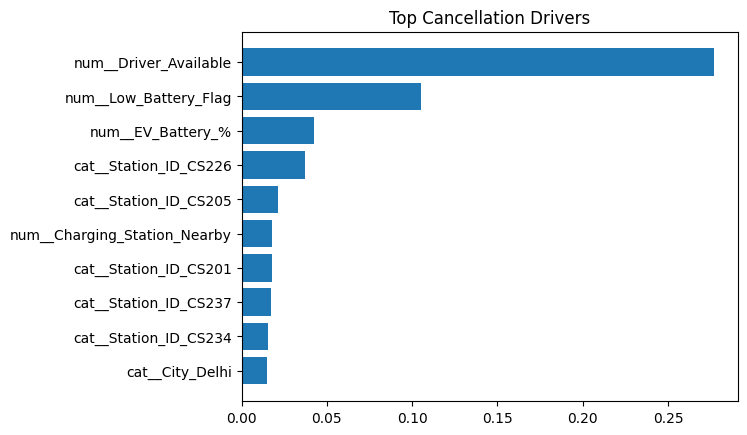

In [69]:
top_features = importance_df.head(10)

plt.figure()
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.title("Top Cancellation Drivers")
plt.show()
